# TASK 3 - by Yağmur Senanur Eroğlu

In [1]:
# Importing the all necessary libraries for the training  
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# This is the cleaned data set we are working with
df = pd.read_csv("apod_cleaned.csv", sep=';')
df[['date', 'title', 'media_url', 'explanation','keywords', 'clean_explanation', 'image_data', 'label']].reset_index(drop=True)

,date,title,media_url,explanation,keywords,clean_explanation,image_data,label
0,1995-06-16,Neutron Star Earth,https://apod.nasa.gov/apod/image/e_lens.gif,Today's Picture : Explanation : If the Earth c...,"today, picture, explanation, transform, ultra,...",today pictur explan earth could somehow transf...,[[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]\n .....,star
1,1995-06-20,Pleiades Star Cluster,https://apod.nasa.gov/apod/image/pleiades2.gif,"Today's Picture : June 20, 1995 The Pleiades S...","today, picture, June, Pleiades, Star, Cluster,...",today pictur june pleiad star cluster pictur m...,[[[0.06666667 0.04313725 0.0627451 ]\n [0.058...,star
2,1995-06-21,Supernova 1987a Aftermath,https://apod.nasa.gov/apod/image/sn1987a_hst.gif,"Today's Picture : June 21, 1995 The Aftermath ...","today, picture, June, Aftermath, Great, Supern...",today pictur june aftermath great supernova pi...,[[[0.89019608 0.89019608 0.89019608]\n [0.670...,star
3,1995-06-22,Earth from Apollo 17,https://apod.nasa.gov/apod/image/earth_a17.gif,In 1972 Astronauts on the United States's last...,"Astronauts, lunar, mission, Apollo, take, pict...",astronaut unit statess last lunar mission apol...,[[[0.03529412 0. 0. ]\n [0.050...,other
4,1995-06-23,Gamma Ray Sky Map,https://apod.nasa.gov/apod/image/egret_gro.gif,"What if you could ""see"" gamma rays ? This comp...","gamma, ray, computer, process, image, represen...",could see gamma ray comput process imag repres...,[[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]\n .....,other
...,...,...,...,...,...,...,...,...
9936,2023-12-26,IC 443 : The Jellyfish Nebula,https://apod.nasa.gov/apod/image/2312/Jellyfis...,Why is this jellyfish swimming in a sea of sta...,"jellyfish, swimming, sea, star, drift, near, b...",jellyfish swim sea star drift near bright star...,[[[0.22745098 0.28235294 0.31372549]\n [0.196...,nebula
9937,2023-12-27,Rainbow Aurora over Icelandic Waterfall,https://apod.nasa.gov/apod/image/2312/ArchFall...,"Yes, but can your aurora do this ? First, yes,...","yes, aurora, look, like, rainbow, different, p...",ye aurora first ye aurora look like rainbow ev...,[[[0.08235294 0.08627451 0.10588235]\n [0.086...,star
9938,2023-12-28,Jupiter and the Geminid,https://apod.nasa.gov/apod/image/2312/G0030446...,"For a brief moment, this brilliant fireball me...","brief, moment, brilliant, fireball, meteor, ou...",brief moment brilliant firebal meteor outshon ...,[[[0.06666667 0.09019608 0.08235294]\n [0.066...,star
9939,2023-12-29,Shakespeare in Space,https://apod.nasa.gov/apod/image/2312/STScI-Ur...,"In 1986, Voyager 2 became the only spacecraft ...","Voyager, spacecraft, explore, ice, giant, plan...",voyag becam spacecraft explor ice giant planet...,[[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]\n .....,other


In [3]:
# Loading the data set
# Image normalization has already been included in Task 1

X_image_train = np.load( "X_image_train.npy")
X_image_val = np.load("X_image_val.npy")
X_image_test = np.load("X_image_test.npy")

# Text input
X_text_train = np.load("X_text_train.npy")
X_text_val = np.load("X_text_val.npy")
X_text_test = np.load("X_text_test.npy")

# Labels (already one-hot encoded)
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
y_test = np.load("y_test.npy")

In [4]:
# Step 1: Prepare class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights_array))

In [5]:
#CNN branch
# this part of the code trains the image
image_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3,3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x) # I added extra convolution layers to improve the accuracy
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)

In [6]:
# LSTM branch

text_input = Input(shape=(X_text_train.shape[1],))  # Use pre-tokenized input shape
embedding = Embedding(input_dim=10000, output_dim=64)(text_input)
lstm = LSTM(64)(embedding)


In [7]:
# Combine branches
# combines both CNN branch and the LSTM branch 
combined = Concatenate()([x, lstm])
output = Dense(y_train.shape[1], activation='softmax')(combined)

model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
#this part of the code initiated the training process
history = model.fit(
    [X_image_train, X_text_train], y_train,
    validation_data=([X_image_val, X_text_val], y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights 
)
test_loss, test_acc = model.evaluate([X_image_test, X_text_test], y_test) # evaluates you test data to see the accuracy
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}") # prints the final test accuracy

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 99s 451ms/step - accuracy: 0.4063 - loss: 1.3817 - val_accuracy: 0.5091 - val_loss: 1.3185
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 437ms/step - accuracy: 0.5048 - loss: 1.3519 - val_accuracy: 0.6781 - val_loss: 0.9013
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 434ms/step - accuracy: 0.6337 - loss: 0.9644 - val_accuracy: 0.6026 - val_loss: 0.8897
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 433ms/step - accuracy: 0.6430 - loss: 0.8247 - val_accuracy: 0.6972 - val_loss: 0.7331
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 94s 432ms/step - accuracy: 0.6847 - loss: 0.7504 - val_accuracy: 0.5936 - val_loss: 0.8785
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 436ms/step - accuracy: 0.6691 - loss: 0.6870 - val_accuracy: 0.7052 - val_loss: 0.6865
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 95s 436ms/step - accuracy: 0.7340 - loss: 0.5488 - val_accuracy: 0.6408 - val_loss: 0.8380
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 96s 439ms/step - accuracy: 0.7183 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


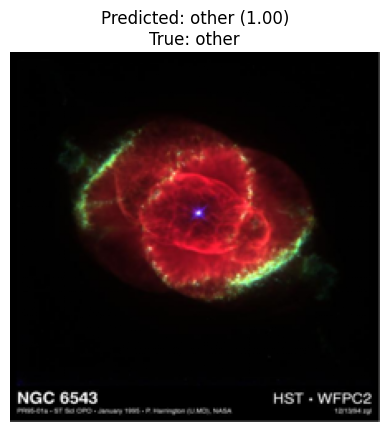

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Pick a random index from your test set
idx = np.random.randint(0, len(X_image_test))

# Get the image and text input
img = X_image_test[idx]
txt = X_text_test[idx]

# Model expects batch dimension
img_input = np.expand_dims(img, axis=0)
txt_input = np.expand_dims(txt, axis=0)

# Predict
pred_probs = model.predict([img_input, txt_input])
pred_class = np.argmax(pred_probs)
confidence = np.max(pred_probs)

# Map class index to label name
label_names = list(df['label'].unique())
pred_label = label_names[pred_class]
true_label = label_names[np.argmax(y_test[idx])]

# Show the image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_label} ({confidence:.2f})\nTrue: {true_label}")
plt.show()


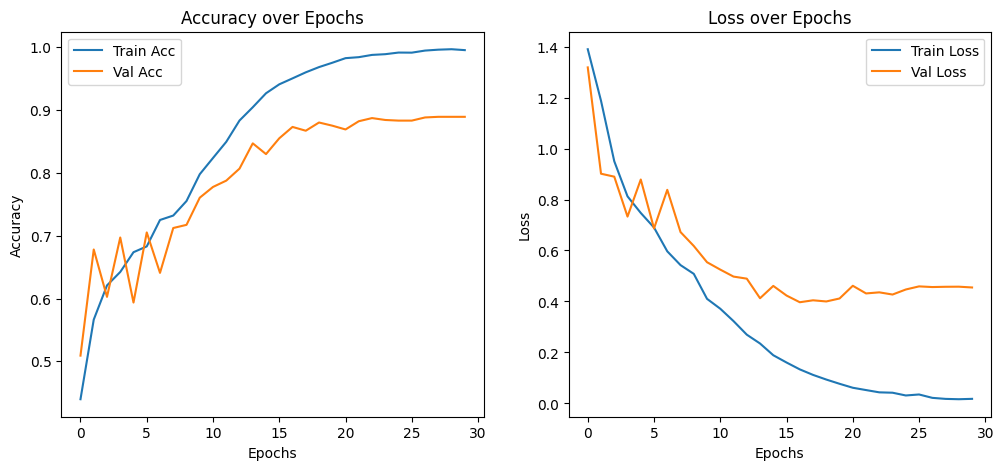

In [11]:
# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Predict class probabilities on test data
y_pred_probs = model.predict([X_image_test, X_text_test])

# Step 2: Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Step 4: Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 5: Full classification report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['galaxy', 'nebula', 'other', 'star']))


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step
✅ Test Accuracy: 0.8934

📊 Classification Report:
              precision    recall  f1-score   support

      galaxy       0.86      0.60      0.71        10
      nebula       0.99      0.96      0.97       462
       other       0.86      0.94      0.90       870
        star       0.88      0.79      0.83       647

    accuracy                           0.89      1989
   macro avg       0.90      0.82      0.85      1989
weighted avg       0.89      0.89      0.89      1989



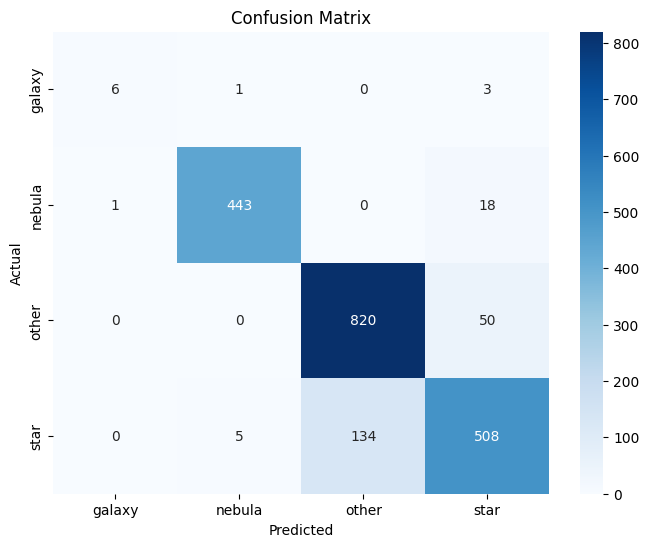

In [ ]:
#confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
labels = ['galaxy', 'nebula', 'other', 'star']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [19]:
#cross validation
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

kf = KFold(n_splits=3, shuffle=True, random_state=42)
acc_scores = []

for train_idx, val_idx in kf.split(X_image_train):
    x_img_train_cv, x_img_val_cv = X_image_train[train_idx], X_image_train[val_idx]
    x_txt_train_cv, x_txt_val_cv = X_text_train[train_idx], X_text_train[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

    temp_model = clone_model(model)
    temp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    temp_model.fit([x_img_train_cv, x_txt_train_cv], y_train_cv, epochs=3, verbose=0)
    
    _, acc = temp_model.evaluate([x_img_val_cv, x_txt_val_cv], y_val_cv, verbose=0)
    acc_scores.append(acc)

print(f"🧪 Cross-validation Accuracies: {acc_scores}")
print(f"📊 Average CV Accuracy: {np.mean(acc_scores):.4f}")


🧪 Cross-validation Accuracies: [0.9125000238418579, 0.8727899789810181, 0.9008193016052246]
📊 Average CV Accuracy: 0.8954
